<a href="https://colab.research.google.com/github/falseywinchnet/EpistemicGPT/blob/main/NewGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#copyright joshuah.rainstar@gmail.com 2025
#MIT with attribution

import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F

class RoPE(nn.Module):
    def __init__(self, dim, max_len=4096):
        super().__init__()
        assert dim % 2 == 0
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        self.register_buffer('cos', freqs.cos())
        self.register_buffer('sin', freqs.sin())

    def forward(self, x):
        # x: (B, *, T, D)
        T = x.shape[-2]
        cos = self.cos[:T, :].unsqueeze(0).unsqueeze(0)
        sin = self.sin[:T, :].unsqueeze(0).unsqueeze(0)

        # Adjust shapes for broadcasting if x has extra dims (like n_branch)
        while cos.ndim < x.ndim:
            cos = cos.unsqueeze(0)
            sin = sin.unsqueeze(0)

        x1 = x[..., 0::2]
        x2 = x[..., 1::2]
        y1 = x1 * cos - x2 * sin
        y2 = x1 * sin + x2 * cos
        return torch.stack((y1, y2), dim=-1).flatten(-2)

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear( config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.scale = math.pi / math.sqrt(3.0)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

def trace_nans(name, tensor):
    if torch.isnan(tensor).any():
        print(f"NaN detected in: {name}")
        return True
    return False

class Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.head_dim = config.n_embd // config.n_head
        self.n_embd = config.n_embd
        self.n_branch = config.n_branch

        self.q_proj = nn.Linear(config.n_embd, config.n_embd * self.n_branch, bias=config.bias)
        self.k_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.v_proj = nn.Linear(config.n_embd, config.n_embd * self.n_branch, bias=config.bias)
        self.o_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, 1, config.block_size, config.block_size))

        self.rope = RoPE(self.head_dim, max_len=config.block_size)
        self.attn_drop = nn.Dropout(config.dropout)

    def forward(self,a, x):
        B, T, C = x.shape
        NB, H, D = self.n_branch, self.n_head, self.head_dim

        q = self.q_proj(a).view(B, T, NB, H, D).permute(0, 2, 3, 1, 4)
        k = self.k_proj(x).view(B, T, 1, H, D).permute(0, 2, 3, 1, 4)
        v = self.v_proj(a).view(B, T, NB, H, D).permute(0, 2, 3, 1, 4)

        q, k = self.rope(q), self.rope(k)

        # Raw scores
        att = (q @ k.transpose(-2, -1)) / math.sqrt(D)

        # CAUSAL MASKING
        mask = self.mask[:, :, :, :T, :T]
        att = att.masked_fill(mask == 0, float("-inf"))

        # BRANCH ROUTING (dim=1)
        # To avoid NaN on the softmax, we must ensure we don't softmax over columns
        # that are entirely -inf (future tokens).
        # We apply nan_to_num after the softmax or use a safe softmax.
        soft_probs = F.softmax(att, dim=1)
        soft_probs = torch.nan_to_num(soft_probs, nan=0.0)

        # STE LOGIC
        with torch.no_grad():
            # Create hard mask: 1.0 for max branch, 0.0 otherwise
            max_val = soft_probs.max(dim=1, keepdim=True)[0]
            hard_mask = (soft_probs == max_val).float()

        route_mask = (hard_mask - soft_probs).detach() + soft_probs

        # TEMPORAL ATTENTION (dim=-1)
        # We collapse the branch dimension using the max to find global importance
        att_max, _ = att.max(dim=1)
        attn_probs = F.softmax(att_max, dim=-1)
        attn_probs = self.attn_drop(attn_probs)

        # Composition: (B, NB, H, T, T)
        # Combine temporal weights and the branch router
        combined_weights = attn_probs.unsqueeze(1) * route_mask

        y = (combined_weights @ v).sum(dim=1)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        out = self.o_proj(y)
        return out


class VectorizedConstellationAttention(nn.Module):
    def __init__(
        self,
        d_model: int,
        n_branch: int,
        palette_hw: int = 32,
        max_k: int = 12,
        rel_hid: int = 64,
        bias: bool = False,
        use_delta: bool = True,
        rope_max_len: int = 4096,
    ):
        super().__init__()
        assert d_model % 2 == 0
        self.d = d_model
        self.BR = n_branch
        self.Ph = self.Pw = palette_hw
        self.Kmax = max_k
        self.use_delta = use_delta

        # Projections
        self.i_proj = nn.Linear(d_model, n_branch * d_model, bias=bias)
        self.p_proj = nn.Linear(d_model, d_model, bias=bias)

        # Use YOUR fixed RoPE everywhere (Q and K)
        self.rope = RoPE(d_model, max_len=rope_max_len)

        # Persistent palette: [D, Ph, Pw]
        self.palette = nn.Parameter(torch.randn(d_model, self.Ph, self.Pw) * (d_model ** -0.5))

        # Relational MLP: input = G_row (K) + anchor_dot (1) + optional delta (1)
        rel_in = self.Kmax + 1 + (1 if use_delta else 0)
        self.rel_mlp = nn.Sequential(
            nn.Linear(rel_in, rel_hid),
            nn.GELU(),
            nn.Linear(rel_hid, rel_hid),
            nn.GELU(),
        )
        self.coord_head = nn.Linear(rel_hid, 2)
        self.mix_head   = nn.Linear(rel_hid, 1)

        # Output projection
        self.Wo = nn.Parameter(torch.randn(n_branch, d_model, d_model) * (d_model ** -0.5))

    def forward(self, x):
        B, T, D = x.shape
        K = self.Kmax
        scale = D ** -0.5
        device = x.device

        # ------------------------------------------------------------
        # 1) Projections + FIXED RoPE
        # ------------------------------------------------------------
        I = self.i_proj(x).view(B, T, self.BR, D).transpose(1, 2).contiguous()  # [B,BR,T,D]
        P = self.p_proj(x)                                                     # [B,T,D]

        I = self.rope(I)                                # [B,BR,T,D]
        P = self.rope(P.unsqueeze(1)).squeeze(1)         # [B,T,D]

        # ------------------------------------------------------------
        # 2) Pass A: logits + causal + optional mask + topk
        # ------------------------------------------------------------
        logits = torch.matmul(I, P.unsqueeze(1).transpose(-1, -2)) * scale     # [B,BR,T,T]

        causal = torch.tril(torch.ones((T, T), device=device, dtype=torch.bool)).view(1, 1, T, T)
        allow = causal


        logits = logits.masked_fill(~allow, float("-inf"))

        k_eff = min(K, T)
        topk_val, topk_idx = torch.topk(logits, k=k_eff, dim=-1)  # [B,BR,T,k_eff]

        # Pad to K so downstream dims stay constant (MLP expects K features)
        if k_eff < K:
            pad = K - k_eff
            topk_val = torch.cat([topk_val, topk_val.new_full((B, self.BR, T, pad), float("-inf"))], dim=-1)
            topk_idx = torch.cat([topk_idx, topk_idx.new_zeros((B, self.BR, T, pad))], dim=-1)

        # Valid neighbors: avoid poisoning G/z/w with -inf slots
        keep = torch.isfinite(topk_val)  # [B,BR,T,K]
        keep_f = keep.float()

        # If some query has *no* valid neighbor (can happen if user mask nukes all),
        # force self as a fallback.
        all_bad = ~keep.any(dim=-1, keepdim=True)  # [B,BR,T,1]
        if all_bad.any():
            t_idx = torch.arange(T, device=device).view(1, 1, T, 1).expand(B, self.BR, T, 1)
            topk_idx = torch.where(all_bad, t_idx, topk_idx)
            topk_val = torch.where(all_bad, topk_val.new_zeros(()), topk_val)  # give it a finite score
            keep = torch.isfinite(topk_val)
            keep_f = keep.float()

        # ------------------------------------------------------------
        # 3) Gather neighbors + relational features (masked)
        # ------------------------------------------------------------
        b_idx = torch.arange(B, device=device).view(B, 1, 1, 1)
        P_sel = P[b_idx, topk_idx]  # [B,BR,T,K,D]

        P_sel_norm = F.normalize(P_sel, dim=-1) * keep_f.unsqueeze(-1)

        I_norm = F.normalize(I, dim=-1).unsqueeze(3)  # [B,BR,T,1,D]

        feat_a = (I_norm * P_sel_norm).sum(dim=-1).clamp(-1.0, 1.0)
        feat_a = feat_a * keep_f  # [B,BR,T,K]

        G = torch.matmul(P_sel_norm, P_sel_norm.transpose(-1, -2)).clamp(-1.0, 1.0)  # [B,BR,T,K,K]
        G = G * keep_f.unsqueeze(-1) * keep_f.unsqueeze(-2)

        feats = [G, feat_a.unsqueeze(-1)]
        if self.use_delta:
            t_range = torch.arange(T, device=device).view(1, 1, T, 1)
            delta = (t_range - topk_idx).float().clamp_min(0.0) / max(1.0, float(T))
            delta = delta * keep_f
            feats.append(delta.unsqueeze(-1))

        rel_input = torch.cat(feats, dim=-1)  # [B,BR,T,K, K+1(+1)]

        # ------------------------------------------------------------
        # 4) MLP -> coords + weights (masked softmax)
        # ------------------------------------------------------------
        h = self.rel_mlp(rel_input)                              # [B,BR,T,K,rel_hid]
        z = torch.tanh(self.coord_head(h))                       # [B,BR,T,K,2]
        mix_logits = self.mix_head(h).squeeze(-1)                # [B,BR,T,K]
        mix_logits = mix_logits.masked_fill(~keep, float("-inf"))

        w = torch.softmax(mix_logits, dim=-1)
        w = torch.nan_to_num(w, nan=0.0, posinf=0.0, neginf=0.0)  # extra safety

        # ------------------------------------------------------------
        # 5) Sample palette + aggregate
        # ------------------------------------------------------------
        batch_pal = self.palette.unsqueeze(0).expand(B * self.BR, -1, -1, -1)  # [B*BR,D,Ph,Pw]
        grid = z.reshape(B * self.BR, T, K, 2)                                 # [B*BR,T,K,2]

        samples = F.grid_sample(
            batch_pal,
            grid,
            mode="bilinear",
            padding_mode="border",
            align_corners=True,
        )  # [B*BR, D, T, K]

        samples = samples.view(B, self.BR, D, T, K).permute(0, 1, 3, 4, 2)     # [B,BR,T,K,D]
        V_out = (samples * w.unsqueeze(-1)).sum(dim=3)                          # [B,BR,T,D]

        y = torch.einsum("nrtd,rdm->nrtm", V_out, self.Wo).mean(dim=1)         # [B,T,D]
        return y


def norm(x):
    return F.rms_norm(x, (x.size(-1),))


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.think = VectorizedConstellationAttention(config.n_embd,config.n_branch)
        self.attn = Attention(config)
        self.mlp = MLP(config)
        self.mlp2 = MLP(config)

    def forward(self, x):
        B, T, C = x.shape
        a = self.think(x)
        a = a + self.mlp(a)
        x = x +  self.attn(norm(a), norm(x))
        x = x + self.mlp2(norm(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 1
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    n_branch: int = 4 # Number of branches in Attention

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        # Base noise seed (learned) for map generation

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        return n_params


    def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()
        x = self.transformer.wte(idx) # token

        # forward the GPT model itself
        for block in self.transformer.h:
            x  = block(x)
        B, T, C = x.shape

        x = norm(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss




In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [3]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [4]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )



config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=6,
    n_embd=128,
    n_head =1,
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
model = GPT(config)
model = torch.compile(model)
model = model.to(device)


number of parameters: 4.29M


In [5]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()
          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
W0105 22:49:50.020000 936 torch/_inductor/utils.py:1558] [2/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and yo

4.277576446533203
3.5246927738189697
3.4951136112213135
3.201849937438965
3.1176576614379883
3.040306568145752
2.930316925048828
2.884458065032959
2.7933478355407715
2.739485502243042
2.7411327362060547
2.658965826034546
2.6956729888916016
2.676539182662964
2.67113995552063
2.5994229316711426
2.577633857727051
2.586418628692627
2.618211269378662
2.5867409706115723
2.5759541988372803
2.5471277236938477
2.536789894104004
2.5539186000823975
2.5518696308135986
2.5327043533325195
2.539564847946167
2.5472846031188965
2.5054540634155273
2.4694457054138184
2.491516590118408
2.4875833988189697
2.4992027282714844
2.4651947021484375
2.473219394683838
2.462993621826172
2.438826084136963
2.438944101333618
2.434572219848633
2.4230880737304688
2.414565086364746
2.3797800540924072
2.4009408950805664
2.37880277633667
2.3976693153381348
2.3414194583892822
2.3804893493652344
2.371567487716675
2.3862180709838867
2.367199420928955
2.339498996734619
2.330512762069702
2.331695079803467
2.342974901199341
2.31

KeyboardInterrupt: 

In [18]:
# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

1.3186094760894775
1.2834484577178955
1.3019572496414185
1.3036046028137207
1.265223741531372
1.2919291257858276
1.3702688217163086
1.3180965185165405
1.2135009765625
1.3393348455429077
1.259506344795227
1.2673537731170654
1.2924010753631592
1.2925794124603271
1.2927391529083252
1.287895679473877
1.2314845323562622
1.2759478092193604
1.2787171602249146
1.3658279180526733
1.2688664197921753
1.2520473003387451
1.3169682025909424
1.2781422138214111
1.2809158563613892
1.2820826768875122
1.2869012355804443
1.3287055492401123
1.328109622001648
1.2669986486434937
1.2567886114120483
1.314028263092041
1.2213621139526367
1.3245295286178589
1.2756513357162476
1.3023432493209839
1.3100858926773071
1.337563395500183
1.3022234439849854
1.2300965785980225
1.2996848821640015
1.2980031967163086
1.2522106170654297
1.2683062553405762
1.213493824005127
1.3016313314437866
1.309885025024414
1.3023202419281006
1.3431788682937622
1.3341031074523926
1.3733711242675781
1.2912306785583496
1.3017873764038086
1.37

KeyboardInterrupt: 

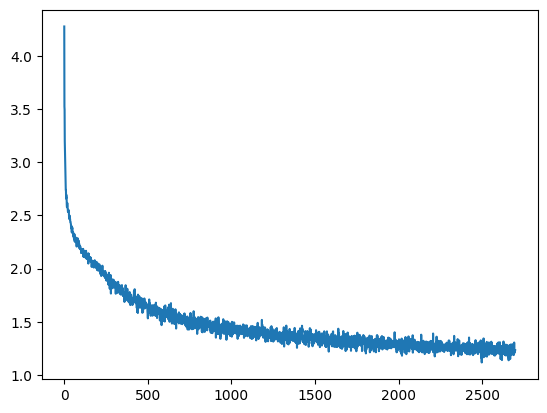

In [19]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

In [20]:
import numpy as np
import torch
import torch.nn.functional as F

@torch.no_grad()
def eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=None):
    """
    Computes BPC and PPL on random contiguous slices.
    Assumes ?1 the loss returned by model(x, y) is mean NLL per token.
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    total_nll_nat = 0.0
    total_tokens = 0

    for _ in range(max_batches):
        if len(val_ids) <= block_size + 1:
            break

        start = np.random.randint(0, len(val_ids) - block_size - 1)
        x = torch.tensor(val_ids[start:start+block_size], dtype=torch.long, device=device)[None, :]
        y = torch.tensor(val_ids[start+1:start+block_size+1], dtype=torch.long, device=device)[None, :]

        # IMPORTANT: pass y so the model returns a sequence loss
        logits, loss = model(x, y)

        # If model doesn’t return loss for some reason, compute it safely
        if loss is None:
            # Handle both possible logits shapes
            if logits.dim() == 3 and logits.size(1) == x.size(1):
                # full sequence logits [B, T, V]
                B, T, V = logits.shape
                ce = F.cross_entropy(logits.view(-1, V), y.view(-1), reduction="mean")
                nll_nat = ce.item()
                tokens = T * B
            elif logits.dim() == 2:
                # last-step logits [B, V] -> only evaluate the last target
                ce = F.cross_entropy(logits, y[:, -1], reduction="mean")
                nll_nat = ce.item()
                tokens = logits.size(0)  # B tokens (here 1)
            else:
                raise ValueError(f"Unexpected logits shape: {tuple(logits.shape)}")
        else:
            # ?1 assume this is mean NLL per token (standard)
            nll_nat = float(loss.item())
            tokens = x.numel()  # B * T

        total_nll_nat += nll_nat * tokens
        total_tokens  += tokens

    if total_tokens == 0:
        return float("nan"), float("nan")

    avg_nll_nat = total_nll_nat / total_tokens
    bpc = avg_nll_nat / np.log(2.0)
    ppl = float(np.exp(avg_nll_nat))
    return bpc, ppl,avg_nll_nat

bpc, ppl ,ce = eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=device)
print("BPC:", bpc, "Perplexity:", ppl, "VAL LOSS:", ce)


BPC: 2.2953995254438895 Perplexity: 4.908899141920653 VAL LOSS: 1.5910497093200684


'''
Negative log-likelihood (NLL): The metric underneath both BPC and PPL is the average negative log probability assigned to the true next token. Lower NLL means the model is assigning higher probability to correct targets → better performance.

BPC = NLL in bits per token. Lower BPC means fewer bits are needed to encode the text, i.e. the model compresses language better. A perfect model would reach 0.0 BPC.

PPL = exp(NLL). It represents the "effective branching factor" (how many equally likely next tokens the model is as uncertain between). Lower perplexity means the model is more confident and accurate. A perfect model would reach 1.0 PPL.
Models with <100k parameters usually collapse to gibberish or never beat 5-gram.
BPC of NGRAM is ~3.5-4
'''

In [21]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
Pray, if my should no; yet I have none.

Nurse, and so, I will you hence in blood!

MERCUNTIO:
We are blown your face: myself, my grace,
To da fall with years and all obes,
That bear of my counsel! My houses have can him,
By looks and bite those bird's will I give me,
I' there's no renow'd the great, such ne'er
From as myself shall I be?

JULIET:
I am name and consent
It madly only had doth Brince a sharg;
Remember this from means to have full mind,
Than, and therefore uses a shame earnes of.

GRY:
I pray you, poo.
I will not shakest not.

KATHARINA:
My cousin, an't sees
On heavens, indled tell a will to denerations,
Are need in an into lived oppose,
And be the strength-owl swear and the king?

RATCLIFF:
With only shall not prayer?
Friend Snow the quarrel.

PETRUCHIO:
And shame his blood. But thoughts:
Takest, and man; but I will not faith
To make a help to time entertain great--
Why, Mista, some one to take the catesfore.

PETRUCHIO:
I am his de

In [22]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.001
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
And then I have some so much as the shame,
And then I have the state of the state,
And then I have the state of the state,
And the thinks of men of the state of my son,
And then the state of the state of my son,
And then the state of the state of my son,
And that the state of the state of my father.

ROMEO:
The man that shall be the state of my father.

ROMEO:
The dear that shall be so much as the state,
And then the state of the state of my father.

ROMEO:
And then I shall be so much as the state,
And the think of the state of the state,
And the state of the state of the state,
And that the state of the state of the state,
And the state of the state and the state,
And the think the state of the state of my father
That I shall be the state of the state,
And that the state of the state of the state,
That he hath been and the state of the state,
And the state of the state and the state,
And the state of the state and the state,
And stay the state o

In [23]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=3.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:xrwmacVPakegmowand;'
Grua. Or, al
SD;tnovicous-aoe,gine?:
FaPe,-groB
I vereptegiho?Gless, fixgnet-g&welX sbrobqd
bl grequesG, I'pThyvefoav,fsximfRayh! Axmy:
Why, Sword!'-uptuP Y bPE:'
-fraxfoGdway: K,RNynbuuke:'---Moxmolekings
Thskry!<unk>rwL:
mafswarryns. O!W.s! Hu! rgaz'd Bet!'.
telMquR! nuts hast I fequip-gludCs'C!--jid:, ut, ao alsBod
bnazfer so VangupiCrh, panr'E! SwankVestusiotyC,'grw,: AwaBHN'zE
IkjOHEY:--Yu,' dnoo<unk>a bform Keeped?
CTOPVWFleD, Kit,Esc Vih; Sigh, aot!
Jut drsZIXop! h&sh,Ed: I'lp;'
Wepomne3 O LADy! every-DetsJut
Ttigod'cum-hony less howled, Kingnets
Goundtet,'ni'ibjuteBytbMAW:naw: oh,  iny .
Sanyy-pilwilbalus;
iumber,'tipbnqui,dTa! laNNa,' libe! masquoteV,ion'F?
Nowgiay r<unk>l! I;Xtwocay.--H, lonWipilA,D: w'll
Echosut shojkCApel everle
I,-KELo.
MyMGliY'?-gerpheY HonBW;-GriwfVpjel,IXasT:
Fote Jgg,': Why,t awerati!
YVs,SpOLetT!--OncyLgelFu, orbfidific,-3-I'hreAs wil,s
BunhI?
You,-stwoulagb$OregIt:utnenagh unto:-dusi .
3stwo

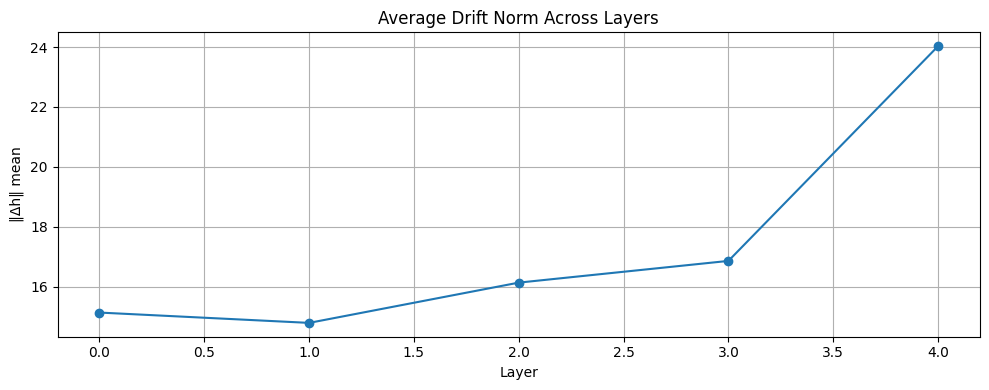

Jacobian rank (final token, projected): 66


In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
     def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        x = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx
    # forward the GPT model itself


    # token + pos emb
    x = model.transformer.wte(tok)
    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb
    def forward_emb(x):
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        x = m=norm(x)
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [26]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = model.transformer.wte(tok)
    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, x.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [27]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


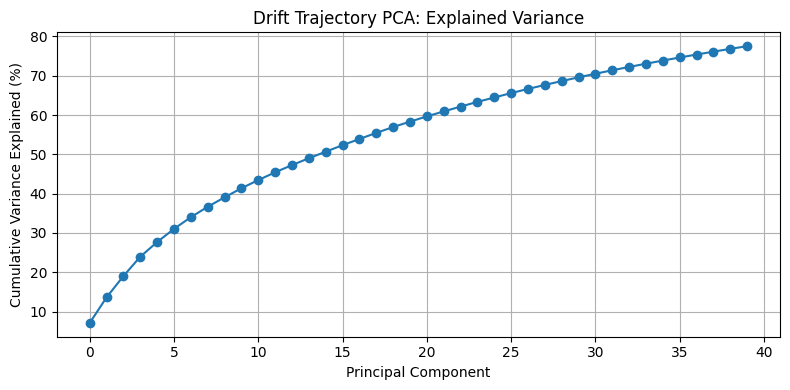

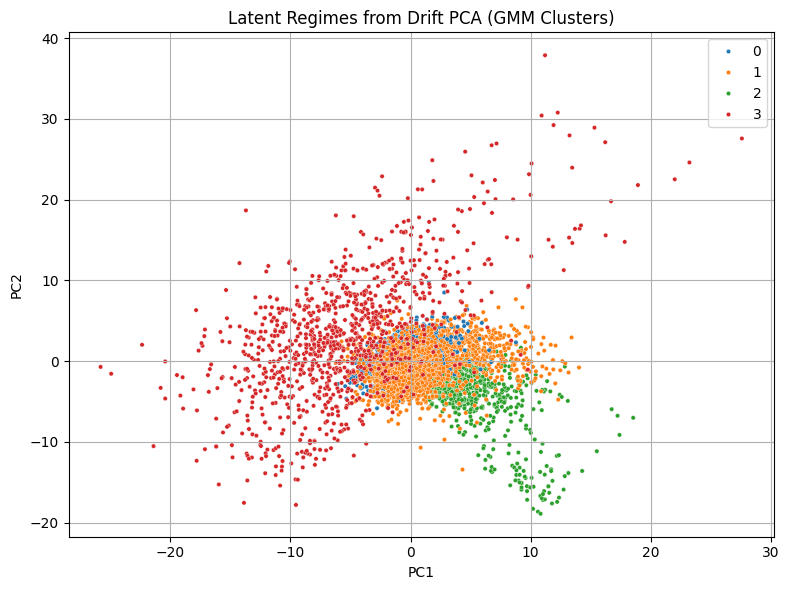

In [28]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)


[Baseline] Val loss: 1.5970

--- Per-Layer Ablation Report ---
Ablate Layer  0: Loss = 1.5646 | Δ = -0.0324
Ablate Layer  1: Loss = 1.5918 | Δ = -0.0051
Ablate Layer  2: Loss = 1.5626 | Δ = -0.0343
Ablate Layer  3: Loss = 1.4884 | Δ = -0.1086
Ablate Layer  4: Loss = 1.5816 | Δ = -0.0153
Ablate Layer  5: Loss = 1.5889 | Δ = -0.0080


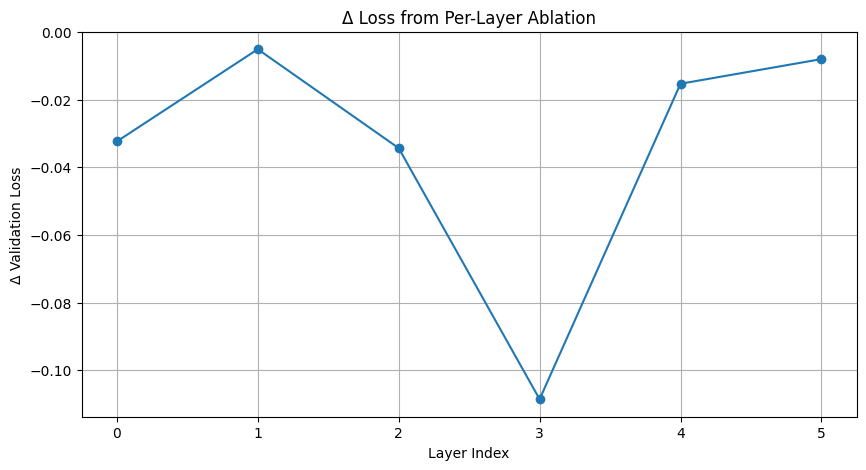

In [29]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

# ==============================
# 🔁 LAYER ABLATION LOGIC BLOCK
# =============================

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 1
# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        for i in range(self.batch_size):
            start = np.random.randint(0, self.total // self.block_size) * self.block_size
            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]
        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

val_dataset = GPUBatchDataset(val_ids, block_size, batch_size=1, device=device)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []
@contextmanager
def layer_ablation_context(model, layers_to_ablate):
    """Context manager that safely ablates selected layers by overriding their .forward."""
    original_forwards = [block.forward for block in model.transformer.h]

    def make_ablation_forward(index, original_fn):
        def ablated_forward(x):
            out = original_fn(x)
            return out
        return ablated_forward

    try:
        for i, block in enumerate(model.transformer.h):
            if i in layers_to_ablate:
                model.transformer.h[i].forward = make_ablation_forward(i, original_forwards[i])
        yield
    finally:
        # Always restore the original forwards
        for i, block in enumerate(model.transformer.h):
            model.transformer.h[i].forward = original_forwards[i]

@torch.no_grad()
def eval_epoch(max_batches=50):
    model.eval()
    total_loss = 0
    for i, (xb, yb) in enumerate(val_loader):
        if i >= max_batches:
            break
        xb, yb = xb[0], yb[0]
        logits, _ = model(xb, yb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B * T, V),
                                yb.view(B * T)).item()
    return total_loss / max_batches

# ---- Evaluate baseline without any ablation ----
with layer_ablation_context(model, layers_to_ablate=set()):
    baseline_val_loss = eval_epoch()
print(f"[Baseline] Val loss: {baseline_val_loss:.4f}")

# ---- Run per-layer ablation safely ----
print("\n--- Per-Layer Ablation Report ---")
results = []
for i in range(model.config.n_layer):
    with layer_ablation_context(model, layers_to_ablate={i}):
        loss = eval_epoch()
    delta = loss - baseline_val_loss
    results.append((i, loss, delta))
    print(f"Ablate Layer {i:2d}: Loss = {loss:.4f} | Δ = {delta:.4f}")

# ---- Plotting ----
layer_ids = [i for i, _, _ in results]
delta_vals = [delta for _, _, delta in results]

plt.figure(figsize=(10, 5))
plt.plot(layer_ids, delta_vals, marker='o')
plt.title("Δ Loss from Per-Layer Ablation")
plt.xlabel("Layer Index")
plt.ylabel("Δ Validation Loss")
plt.grid(True)
plt.show()


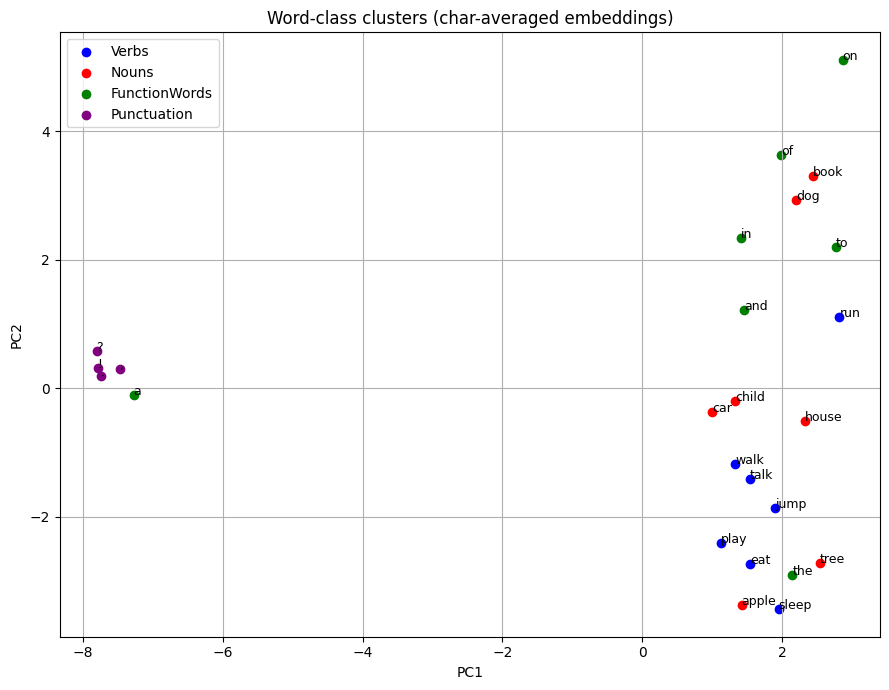

In [30]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [31]:
PATH = "model_weights.pth"

# Save only the model's learned parameters
torch.save(model.state_dict(), PATH)